In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten,MaxPooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import cv2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.regularizers import l2
import tensorflow
from tensorflow.keras.applications import ResNet50

# Convolutional Neural network

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Reading the dataset

In [ ]:
path ="/content/drive/MyDrive/geletawChapter/OnOriginalData/original"

In [ ]:
labels = ["Adino", "SCC", "SIL"]

In [ ]:
image_data,label_data = [],[]
print("start reading")
for l in labels:
    data_path = os.path.join(path,l)
    for f in os.listdir(data_path):
        image = cv2.imread(os.path.join(data_path, f))
        image = cv2.resize(image, (144,144))
        image_data.append(image)
        label_data.append(labels.index(l)) ## only taking index of the label (Eg. 1 for Normal, 2 for Precancer ...)
print("Finished")

start reading
Finished


### Displaying sample images

In [ ]:
image_data = np.array(image_data)

In [ ]:
label_data = np.array(label_data)

In [ ]:
sample_image = image_data[1]
sample_image_label = label_data[1]

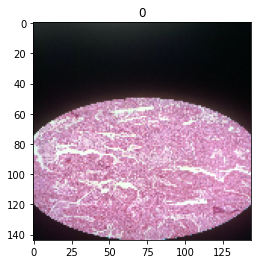

In [ ]:
plt.imshow(sample_image, cmap='gray')
plt.title(sample_image_label)
plt.show()

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(image_data, label_data, test_size = 0.3, shuffle = True)

In [ ]:
train_x.shape

(325, 144, 144, 3)

In [ ]:
val_x.shape

(140, 144, 144, 3)

In [ ]:
train_y_cat = to_categorical(train_y, num_classes = 3)
val_y_cat = to_categorical(val_y, num_classes = 3)

In [ ]:
train_y_cat.shape

(325, 3)

#### Building CNN model

In [ ]:
def first_cnn():
    model = Sequential()
    model.add(Conv2D(256, (3,3), activation = 'relu', input_shape=(144,144,3)))
    model.add(Conv2D(128, (3,3), activation ='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3,3), activation ='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(3, activation = 'softmax', kernel_regularizer=regularizers.l2(l2=1e-4), activity_regularizer=regularizers.l2(1e-5)))
    model.compile(loss ='categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'])
    return model

In [ ]:
def second_cnn():
  model = Sequential()
  model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(144, 144, 3)))
  model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(3, activation='softmax',kernel_regularizer=regularizers.l2(l2=1e-4), activity_regularizer=regularizers.l2(1e-5)))
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
  return model

In [ ]:
def resnet50():
  model = ResNet50(weights = 'imagenet',include_top=False, input_shape=(144, 144, 3))
  model.trainable = False
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(256, activation='relu')(flat1)
  output = Dense(3, activation='softmax')(class1)
  model = tensorflow.keras.Model(inputs=model.inputs, outputs=output)
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
  return model

In [ ]:
model =resnet50()

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 72, 72, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 72, 72, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
## early stopping mechanism
es = EarlyStopping(monitor ='val_accuracy', mode = 'max', patience = 10, verbose = 1)

In [ ]:
history = model.fit(train_x, train_y_cat, epochs = 300, verbose = 1, batch_size = 64, validation_data = (val_x, val_y_cat), callbacks = [es])

Epoch 1/300
6/6 [==============================] - 19s 1s/step - loss: 41.3461 - accuracy: 0.4831 - val_loss: 12.9128 - val_accuracy: 0.5643
Epoch 2/300
6/6 [==============================] - 2s 331ms/step - loss: 9.2786 - accuracy: 0.6800 - val_loss: 7.5828 - val_accuracy: 0.6357
Epoch 3/300
6/6 [==============================] - 2s 330ms/step - loss: 2.4710 - accuracy: 0.8062 - val_loss: 3.0589 - val_accuracy: 0.7357
Epoch 4/300
6/6 [==============================] - 2s 331ms/step - loss: 2.4243 - accuracy: 0.7969 - val_loss: 2.6857 - val_accuracy: 0.7500
Epoch 5/300
6/6 [==============================] - 2s 331ms/step - loss: 0.7661 - accuracy: 0.8862 - val_loss: 0.9226 - val_accuracy: 0.9143
Epoch 6/300
6/6 [==============================] - 2s 331ms/step - loss: 0.2325 - accuracy: 0.9569 - val_loss: 1.6118 - val_accuracy: 0.8286
Epoch 7/300
6/6 [==============================] - 2s 328ms/step - loss: 0.2490 - accuracy: 0.9446 - val_loss: 0.8905 - val_accuracy: 0.9143
Epoch 8/300
6

In [ ]:
import json
hst = open(r"C:\Users\user\Desktop\chapter_geletaw\Newdata/firstcnnmodel_hist.json", 'w')
json.dump(history.history, hst)

In [ ]:
model.save_weights("/content/drive/MyDrive/geletawChapter/OnOriginalData/OriginalResnet50.h5")

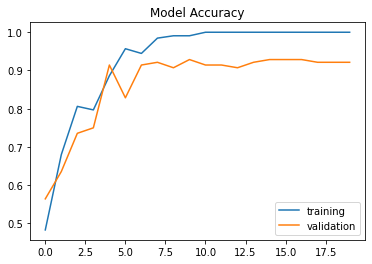

In [ ]:
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label = 'training')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.legend()
plt.show()

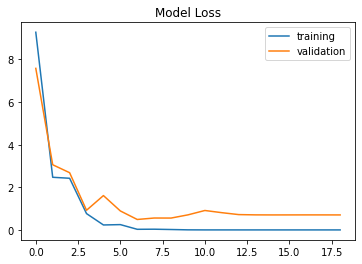

In [ ]:
plt.title('Model Loss')
plt.plot(history.history['loss'][1:], label = 'training')
plt.plot(history.history['val_loss'][1:], label = 'validation')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(val_x)

In [ ]:
y_pred[0]

array([2.3447146e-18, 1.0000000e+00, 6.4166394e-11], dtype=float32)

In [ ]:
y_pred_single = []
for i in y_pred:
    y_pred_single.append(np.argmax(i))

In [ ]:
y_pred_single[0]

1

In [ ]:
val_y[0]

1

In [ ]:
ad = []

for i in val_y:
  if i==0:
    ad.append(i)

In [ ]:
len(ad)

21

In [ ]:
y_pred.shape

(140, 3)

In [ ]:
label_data.shape

(465,)

In [ ]:
import pandas as pd
label_df = pd.DataFrame(y_pred_single)
label_df.groupby(0).size()

0
0    25
1    70
2    45
dtype: int64

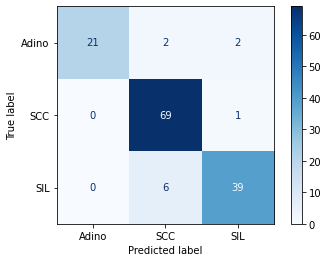

In [ ]:
 
cm = confusion_matrix(y_pred_single,val_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()